# Task

### Pre-defined Code

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

# Downloading all the required libraries


# Importing all the required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import style
from glob import glob
from natsort import natsorted
from tqdm import tqdm
import imageio
from IPython.display import Image
style.use('ggplot')

Mounted at /content/drive


In [ ]:
# It may take some minutes to load the video data for the first time (~5 mins)
# Loading all the images in the drive
videos_images = []

for path in tqdm(natsorted(glob('/content/drive/My Drive/ES666CV/Images/D/*'))):
    sub_path = path + '/*'
    video_frames = []
    for files in natsorted(glob(sub_path)):
        video_frames.append(cv2.imread(files, 1))
    video_frames = np.array(video_frames)
    videos_images.append(video_frames)

# videos_images = np.array(video_frames) # Only possible because all images are of same size

100%|██████████| 8/8 [01:34<00:00, 11.85s/it]


In [ ]:
def show_image_grid(images, M, N, title='Title', figsize=8):
    # Assuming 'images' is a numpy array of shape (num_images, height, width, channels)
    if M==1:
        row_size = figsize
        col_size = figsize//4
    elif N==1:
        row_size = figsize//4
        col_size = figsize
    else:
        row_size, col_size = figsize, figsize

    fig, axes = plt.subplots(M, N, figsize=(row_size, col_size))

    if len(images.shape) < 4:
        images = np.expand_dims(images.copy(), axis=0)

    fig.suptitle(title)
    for i in range(M):
        for j in range(N):
            if M==1 and N==1:
                ax = axes
            elif M == 1 or N==1:
                ax = axes[max(i, j)]
            else:
                ax = axes[i, j]
            index = i * N + j
            if index < images.shape[0]:
                ax.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
            ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
def images_to_gif(frames, video_id):
    with imageio.get_writer(f"{video_id}.gif", mode="I", fps=24) as writer:
        for idx, frame in enumerate(frames):
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            writer.append_data(frame)

def show_gif(video_id):
    with open(f"/content/{video_id}.gif",'rb') as f:
        display(Image(data=f.read(), format='png'))

In [ ]:
for video_idx, video_frames in enumerate(tqdm(videos_images)):
    images_to_gif(video_frames, video_idx)
    show_gif(video_idx)

### Q1: Implement Lucas-Kanade optical flow algorithm [5 Marks]

You have to implement luca-kanade optical flow algorithm from scratch. You can use convol2d function for the same. Show the results on the video dataset in gray

References: <br/>
1. Optical Flow (Shi-Tomasi Corner Detection,Sparse(Lucas-kanade, Horn schunck) & Dense(Gunnar Farneback) )-Part I [[link](https://medium.com/@VK_Venkatkumar/optical-flow-shi-tomasi-corner-detection-sparse-lucas-kanade-horn-schunck-dense-gunnar-e1dae9600df)]
2. Implementing Lucas-Kanade Optical Flow algorithm in Python [[link](https://sandipanweb.wordpress.com/2018/02/25/implementing-lucas-kanade-optical-flow-algorithm-in-python/)]
3. The Math Behind Optical Flow [[link](https://medium.com/building-autonomous-flight-software/math-behind-optical-flow-1c38a25b1fe8)]

In [ ]:
import numpy as np
import cv2
from scipy.signal import convolve2d
from tqdm import tqdm
import matplotlib.pyplot as plt

def compute_derivatives(I1, I2):

    Ix, Iy, It = [], [], []
    for ch in range(3):  # Assuming I1 and I2 have 3 channels
        Ix_ch = convolve2d(I1[:, :, ch], 0.25*np.array([[-1, 1], [-1, 1]]), boundary='symm', mode='same')
        Iy_ch = convolve2d(I1[:, :, ch], 0.25*np.array([[-1, -1], [1, 1]]), boundary='symm', mode='same')
        It_ch = convolve2d(I2[:, :, ch], 0.25*np.array([[1, 1], [1, 1]]), boundary='symm', mode='same') - \
                convolve2d(I1[:, :, ch], 0.25*np.array([[1, 1], [1, 1]]), boundary='symm', mode='same')
        Ix.append(Ix_ch)
        Iy.append(Iy_ch)
        It.append(It_ch)
    return np.mean(Ix, axis=0), np.mean(Iy, axis=0), np.mean(It, axis=0)

def lucas_kanade(I1, I2, window_size=5):
    Ix, Iy, It = compute_derivatives(I1, I2)

    u = np.zeros(I1.shape)    # Velocity in x direction
    v = np.zeros(I1.shape)    # Velocity in y direction

    half_window = window_size // 2

    for i in range(half_window, I1.shape[0] - half_window):
        for j in range(half_window, I1.shape[1] - half_window):
            # Extract the window region
            Ix_window = Ix[i - half_window:i + half_window + 1, j - half_window:j + half_window + 1].flatten()
            Iy_window = Iy[i - half_window:i + half_window + 1, j - half_window:j + half_window + 1].flatten()
            It_window = It[i - half_window:i + half_window + 1, j - half_window:j + half_window + 1].flatten()

            A = np.vstack((Ix_window, Iy_window)).T
            b = -It_window

            # Finding u and v using least squares if A is well-conditioned
            try:
                nu = np.linalg.pinv(A.T @ A) @ (A.T @ b)
                u[i, j] = nu[0]
                v[i, j] = nu[1]
            except np.linalg.LinAlgError:
                u[i, j] = 0
                v[i, j] = 0

    return u, v

def draw_optical_flow(u, v, frame, step=10):
    result = frame.copy()  # Use the color frame directly

    if u.ndim == 3:
        u = np.mean(u, axis=2)
        v = np.mean(v, axis=2)

    for i in range(0, u.shape[0], step):
        for j in range(0, u.shape[1], step):
            if np.hypot(u[i, j], v[i, j]) > 1e-2:  # Threshold to filter noise
                cv2.arrowedLine(result, (j, i), (int(j + v[i, j]), int(i + u[i, j])), (0, 255, 0), 1, tipLength=0.3)
    return result



def optical_flow(frames, video_id):

    optical_flow_frames = []
    for t in range(1, len(frames)):
        I1 = frames[t - 1]
        I2 = frames[t]

        u, v = lucas_kanade(I1, I2)
        u = cv2.GaussianBlur(u, (5, 5), 0)
        v = cv2.GaussianBlur(v, (5, 5), 0)
        I=cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)
        # Visualize flow on the current frame
        flow_frame = draw_optical_flow(u, v, I)
        optical_flow_frames.append(flow_frame)

    images_to_gif(optical_flow_frames, f"{video_id}_optical")
    print("Optical flow GIF created.")

In [ ]:
for video_idx, video_frames in enumerate(tqdm(videos_images)):
    optical_flow(video_frames, video_idx)

 12%|█▎        | 1/8 [04:28<31:21, 268.80s/it]

Optical flow GIF created.


 25%|██▌       | 2/8 [11:16<35:01, 350.22s/it]

Optical flow GIF created.


 38%|███▊      | 3/8 [18:00<31:15, 375.15s/it]

Optical flow GIF created.


 50%|█████     | 4/8 [22:36<22:23, 335.85s/it]

Optical flow GIF created.


 62%|██████▎   | 5/8 [26:11<14:36, 292.19s/it]

Optical flow GIF created.


 75%|███████▌  | 6/8 [29:29<08:40, 260.21s/it]

Optical flow GIF created.


 88%|████████▊ | 7/8 [31:02<03:25, 205.60s/it]

Optical flow GIF created.


100%|██████████| 8/8 [35:50<00:00, 268.84s/it]

Optical flow GIF created.


In [ ]:
for video_idx in tqdm(range(len(videos_images))):
    show_gif(str(video_idx)+'_optical')

### Q2: Image warping using Optical Flow [5 Marks]

Using the algorithm written above, you have to perfrom image warping. <br/>
1. Select any two frames with distance [i, i+8]
2. Compute the optical flow between them.
3. Using the calculated optical flow, warp the ith frame pixel into new image using calculated optical flow values.Compare the new image generated using warping with (i+8)th frame.
4. You can use all the functions that allowed in the previous assignments but you have to write warping algorithm from scratch.

References: <br/>
1. Motion and Optical Flow [[link](https://www.cs.princeton.edu/courses/archive/fall11/cos429/notes/cos429_f11_lecture08_motion.pdf)]
2. Image warping [[link](https://github.com/alisaaalehi/image_warping)]
3. Forward and Backward Warping for Optical Flow-Based Frame Interpolation [[link][https://ieeexplore.ieee.org/document/9722682]]

In [ ]:
def optical_flow_warping(frame_a, frame_b):
    import numpy as np
    u, v = lucas_kanade(frame_a, frame_b)
    if u.ndim == 3:
        u = np.mean(u, axis=2)
        v = np.mean(v, axis=2)

    h, w, c = frame_a.shape

    # Generate grid of coordinates
    grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))

    # Compute new coordinates with optical flow
    new_x = grid_y + v
    new_y = grid_x + u

    # Clip new coordinates to valid range
    new_x = np.clip(new_x, 0, h - 2)
    new_y = np.clip(new_y, 0, w - 2)

    x0 = np.floor(new_x).astype(int)
    y0 = np.floor(new_y).astype(int)
    dx = new_x - x0
    dy = new_y - y0

    # Bilinear interpolation
    warped_frame = np.zeros_like(frame_a, dtype=np.float32)
    for ch in range(c):
        f00 = frame_a[x0, y0, ch]
        f01 = frame_a[x0, y0 + 1, ch]
        f10 = frame_a[x0 + 1, y0, ch]
        f11 = frame_a[x0 + 1, y0 + 1, ch]

        warped_frame[..., ch] = (
            f00 * (1 - dx) * (1 - dy) +
            f01 * (1 - dx) * dy +
            f10 * dx * (1 - dy) +
            f11 * dx * dy
        )

    warped_frame = np.clip(warped_frame, 0, 255).astype(np.uint8)
    return warped_frame


  0%|          | 0/8 [00:00<?, ?it/s]

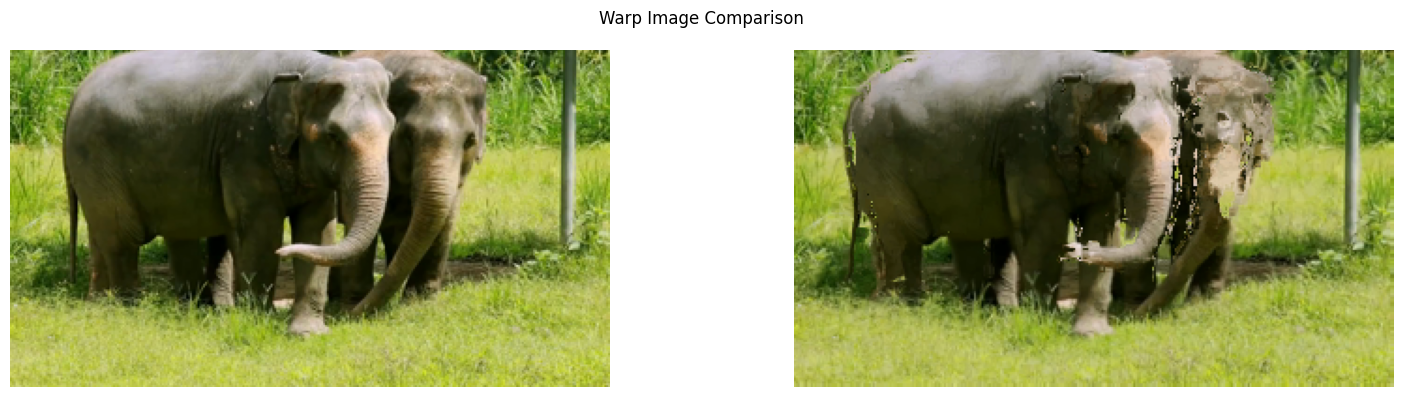

 12%|█▎        | 1/8 [00:06<00:42,  6.13s/it]

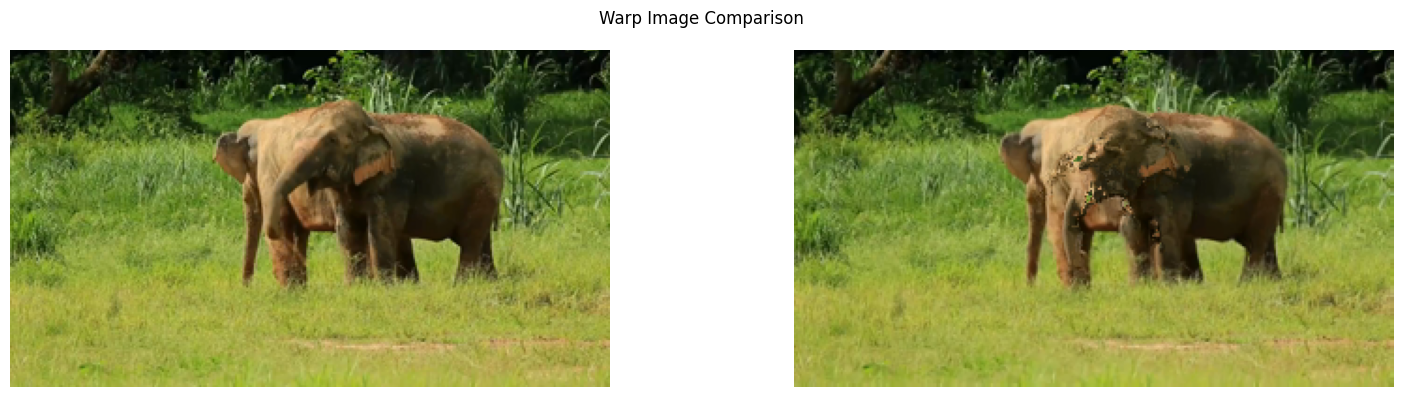

 25%|██▌       | 2/8 [00:10<00:30,  5.06s/it]

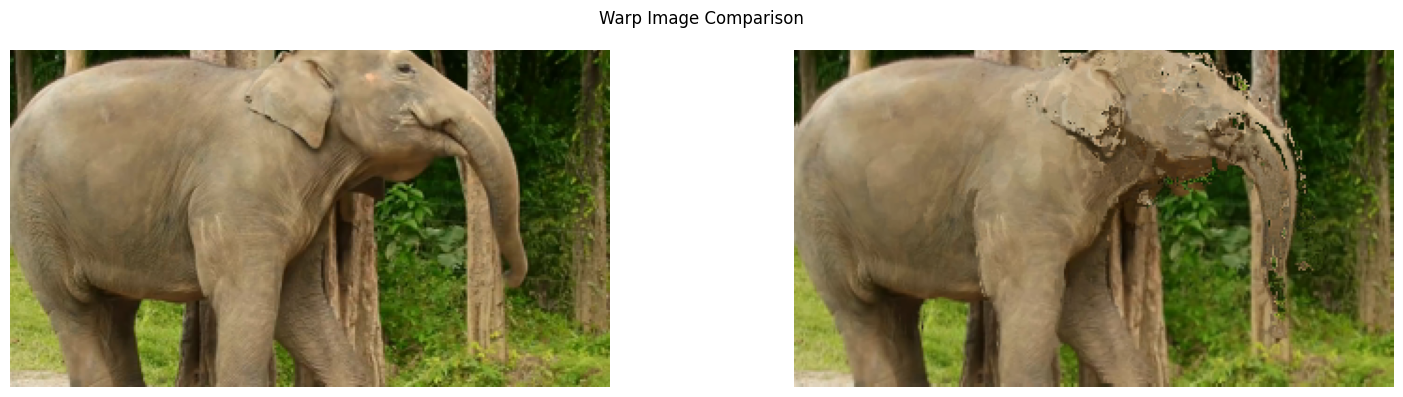

 38%|███▊      | 3/8 [00:14<00:23,  4.72s/it]

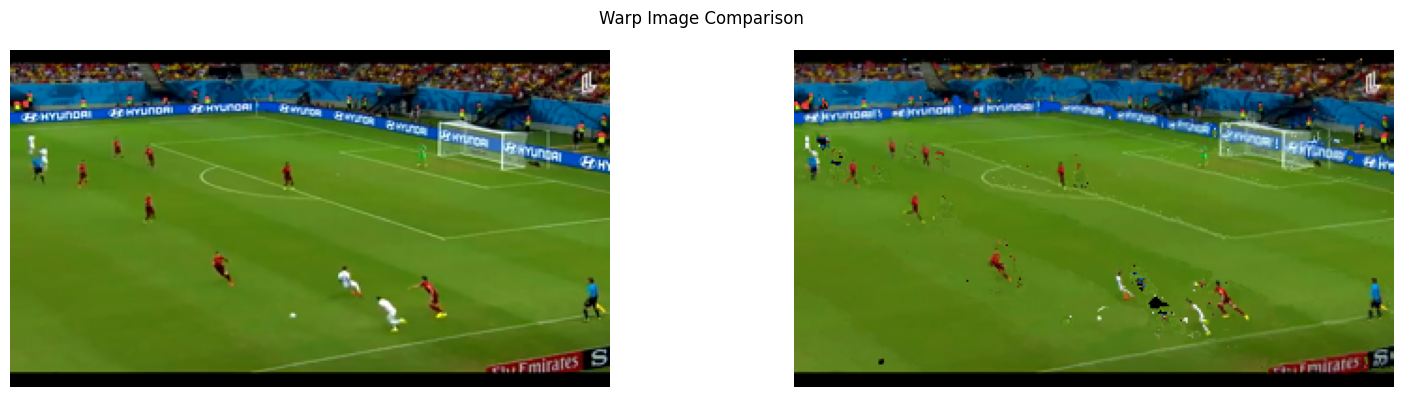

 50%|█████     | 4/8 [00:20<00:21,  5.27s/it]

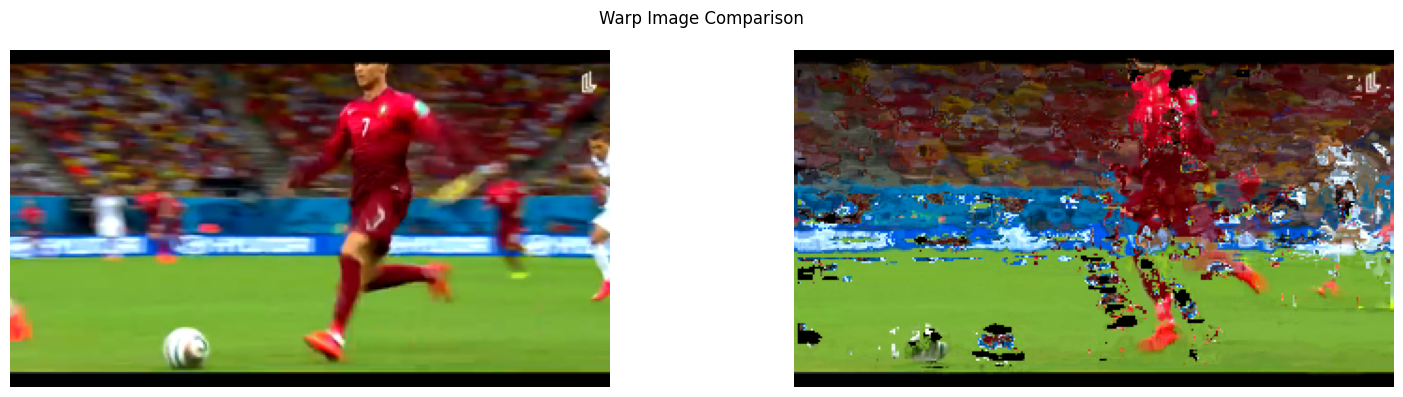

 62%|██████▎   | 5/8 [00:25<00:14,  4.90s/it]

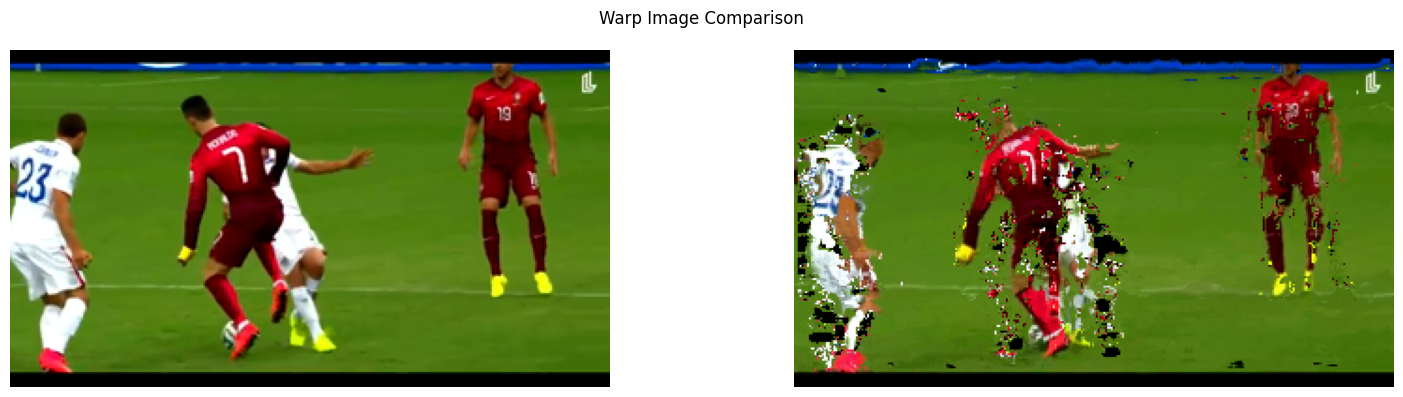

 75%|███████▌  | 6/8 [00:29<00:09,  4.66s/it]

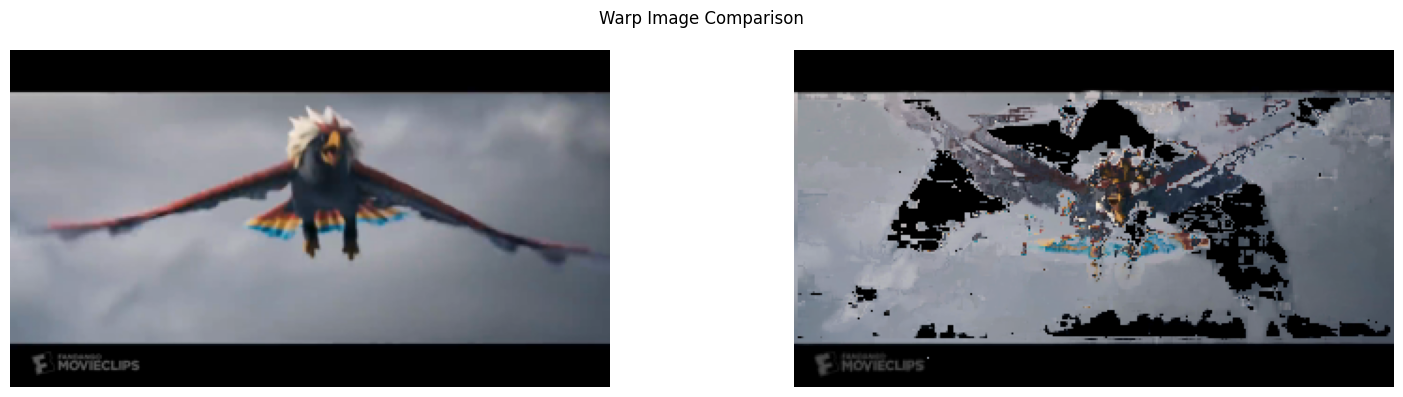

 88%|████████▊ | 7/8 [00:35<00:05,  5.13s/it]

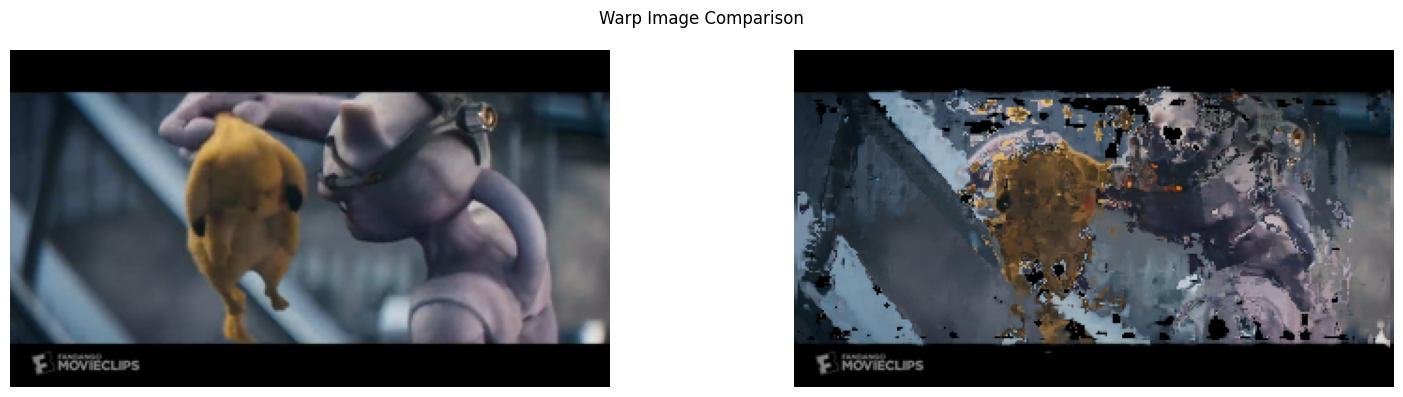

100%|██████████| 8/8 [00:39<00:00,  4.96s/it]


In [ ]:
for video_idx, video_frames in enumerate(tqdm(videos_images)):
    i = 1
    warped_image = optical_flow_warping(video_frames[i], video_frames[i+8])
    show_image_grid(np.array([video_frames[i+5], warped_image]), 1, 2, 'Warp Image Comparison', figsize=16)